In [1]:
from google.colab import drive, files
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import datasets, layers, models
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
device_name = tf.test.gpu_device_name()

# Datasets 75% training - 25% testing


In [3]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/de la u/DL/Deep Learning/Keras/car_data/car_data/train', labels='inferred',
    image_size=(180, 180),
)
validation = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/de la u/DL/Deep Learning/Keras/car_data/car_data/test', labels='inferred', validation_split=0.5,
    subset='training', shuffle=True,
    seed=100,
    image_size=(180, 180),
)
test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/de la u/DL/Deep Learning/Keras/car_data/car_data/test', labels='inferred', validation_split=0.5,
    subset='validation', shuffle=True,
    seed=100,
    image_size=(180, 180),
)

Found 12090 files belonging to 196 classes.
Found 3983 files belonging to 196 classes.
Using 1992 files for training.
Found 3983 files belonging to 196 classes.
Using 1991 files for validation.


# Make Model
## Make the Data Augmentation layer part of my model

*\"There are two important points to be aware of in this case:*

*Data augmentation will run on-device, **synchronously** with the rest of your layers, and benefit from **GPU** acceleration.*

*When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side."*

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2), #results in an output rotating by a random amount in the range [-20% * 2pi, 20% * 2pi].
  layers.RandomTranslation(0.15,0.15)
])

#### Build The model

In [8]:
with tf.device(device_name):
  model = models.Sequential()
  model.add(data_augmentation)
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))#, input_shape=(180, 180, 4)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(196, activation='softmax'))

In [55]:
#model.build(input_shape=(180, 180, 4))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)       

Load code for re-train.

In [12]:
filepath = "/content/drive/MyDrive/de la u/DL/bestModels/bestModels0.27acc" #"/content/drive/MyDrive/de la u/DL/bestModels/bestModels0.28acc"mine is /content/drive/MyDrive/de la u/DL/Deep Learning/Copia de kerasBrayanModelBest24acc.hdf5
with tf.device(device_name):
    model = models.load_model(filepath) #I'm not sure if this is still loading the model into the device

## Callbacks
Implement callback functions for tunning hyperparameters and for saving the model.

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
#save the model with the best performance
checkpoint = ModelCheckpoint(filepath="/content/drive/MyDrive/de la u/DL/bestModels/bestModels{val_accuracy:.1f}acc", 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

# This function keeps the initial learning rate for the first 20 epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schd = LearningRateScheduler(scheduler)

callbacks = [checkpoint, lr_schd]

## Visualize the values of the learning rate.

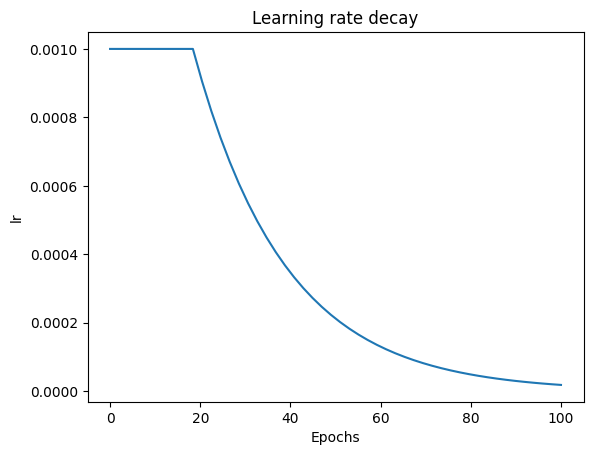

In [15]:
x =  np.linspace(0, 100, 50, endpoint=True)
y = []
lr = 0.001
for epoch in x:
    lr = scheduler(epoch,lr)
    y.append(lr)
plt.figure('lr')
plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("lr")
plt.plot(x, y,)

# Train The Model

- Normalization Layers.
- Avoid Overfitting: Dropout layers.
- Adam Optimizer.
- loss function: Cross-Entropy.

In [ ]:
with tf.device(device_name):
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist2 = model.fit(train, epochs=100, validation_data=validation, callbacks=callbacks)

Epoch 1/100
378/378 [==============================] - ETA: 0s - loss: 1.7278 - accuracy: 0.5441
Epoch 1: val_accuracy improved from -inf to 0.23795, saving model to /content/drive/MyDrive/de la u/DL/bestModels/bestModels0.2acc


378/378 [==============================] - 3200s 8s/step - loss: 1.7278 - accuracy: 0.5441 - val_loss: 4.4083 - val_accuracy: 0.2380 - lr: 0.0010
Epoch 2/100
378/378 [==============================] - ETA: 0s - loss: 1.7384 - accuracy: 0.5374
Epoch 2: val_accuracy did not improve from 0.23795
378/378 [==============================] - 82s 215ms/step - loss: 1.7384 - accuracy: 0.5374 - val_loss: 4.5483 - val_accuracy: 0.2339 - lr: 0.0010
Epoch 3/100
378/378 [==============================] - ETA: 0s - loss: 1.7475 - accuracy: 0.5398
Epoch 3: val_accuracy improved from 0.23795 to 0.24950, saving model to /content/drive/MyDrive/de la u/DL/bestModels/bestModels0.2acc


378/378 [==============================] - 86s 223ms/step - loss: 1.7475 - accuracy: 0.5398 - val_loss: 4.2554 - val_accuracy: 0.2495 - lr: 0.0010
Epoch 4/100
378/378 [==============================] - ETA: 0s - loss: 1.7225 - accuracy: 0.5426
Epoch 4: val_accuracy did not improve from 0.24950
378/378 [==============================] - 78s 203ms/step - loss: 1.7225 - accuracy: 0.5426 - val_loss: 4.4907 - val_accuracy: 0.2264 - lr: 0.0010
Epoch 5/100
378/378 [==============================] - ETA: 0s - loss: 1.7400 - accuracy: 0.5395
Epoch 5: val_accuracy improved from 0.24950 to 0.25502, saving model to /content/drive/MyDrive/de la u/DL/bestModels/bestModels0.3acc


378/378 [==============================] - 85s 222ms/step - loss: 1.7400 - accuracy: 0.5395 - val_loss: 4.0706 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 6/100
378/378 [==============================] - ETA: 0s - loss: 1.7546 - accuracy: 0.5411
Epoch 6: val_accuracy did not improve from 0.25502
378/378 [==============================] - 78s 204ms/step - loss: 1.7546 - accuracy: 0.5411 - val_loss: 4.1103 - val_accuracy: 0.2530 - lr: 0.0010
Epoch 7/100
378/378 [==============================] - ETA: 0s - loss: 1.7614 - accuracy: 0.5351
Epoch 7: val_accuracy did not improve from 0.25502
378/378 [==============================] - 82s 216ms/step - loss: 1.7614 - accuracy: 0.5351 - val_loss: 4.0313 - val_accuracy: 0.2465 - lr: 0.0010
Epoch 8/100
378/378 [==============================] - ETA: 0s - loss: 1.7419 - accuracy: 0.5343
Epoch 8: val_accuracy improved from 0.25502 to 0.28062, saving model to /content/drive/MyDrive/de la u/DL/bestModels/bestModels0.3acc


378/378 [==============================] - 85s 222ms/step - loss: 1.7419 - accuracy: 0.5343 - val_loss: 3.9281 - val_accuracy: 0.2806 - lr: 0.0010
Epoch 9/100
378/378 [==============================] - ETA: 0s - loss: 1.7709 - accuracy: 0.5323
Epoch 9: val_accuracy did not improve from 0.28062
378/378 [==============================] - 81s 212ms/step - loss: 1.7709 - accuracy: 0.5323 - val_loss: 4.3087 - val_accuracy: 0.2490 - lr: 0.0010
Epoch 10/100
378/378 [==============================] - ETA: 0s - loss: 1.7466 - accuracy: 0.5380
Epoch 10: val_accuracy did not improve from 0.28062
378/378 [==============================] - 81s 211ms/step - loss: 1.7466 - accuracy: 0.5380 - val_loss: 4.2827 - val_accuracy: 0.2435 - lr: 0.0010
Epoch 11/100
378/378 [==============================] - ETA: 0s - loss: 1.7179 - accuracy: 0.5472
Epoch 11: val_accuracy did not improve from 0.28062
378/378 [==============================] - 81s 212ms/step - loss: 1.7179 - accuracy: 0.5472 - val_loss: 4.5123 

# Results

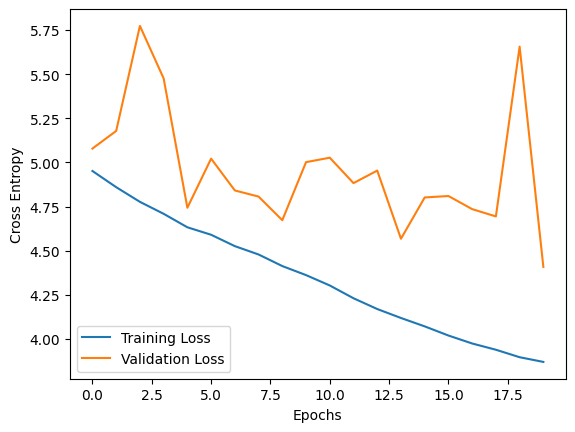

In [ ]:
import matplotlib.pyplot as plt
#plot the training history
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.savefig('model_training_history')
plt.show()

In [60]:
print("Evaluating")
result = model.evaluate(test)
ypred = model.predict(test)
dict(zip(model.metrics_names, result))

Evaluating
63/63 [==============================] - 16s 234ms/step


{'loss': 3.88866925239563, 'accuracy': 0.2707182466983795}

1/1 [==============================] - 0s 25ms/step
accuracy: 0.25


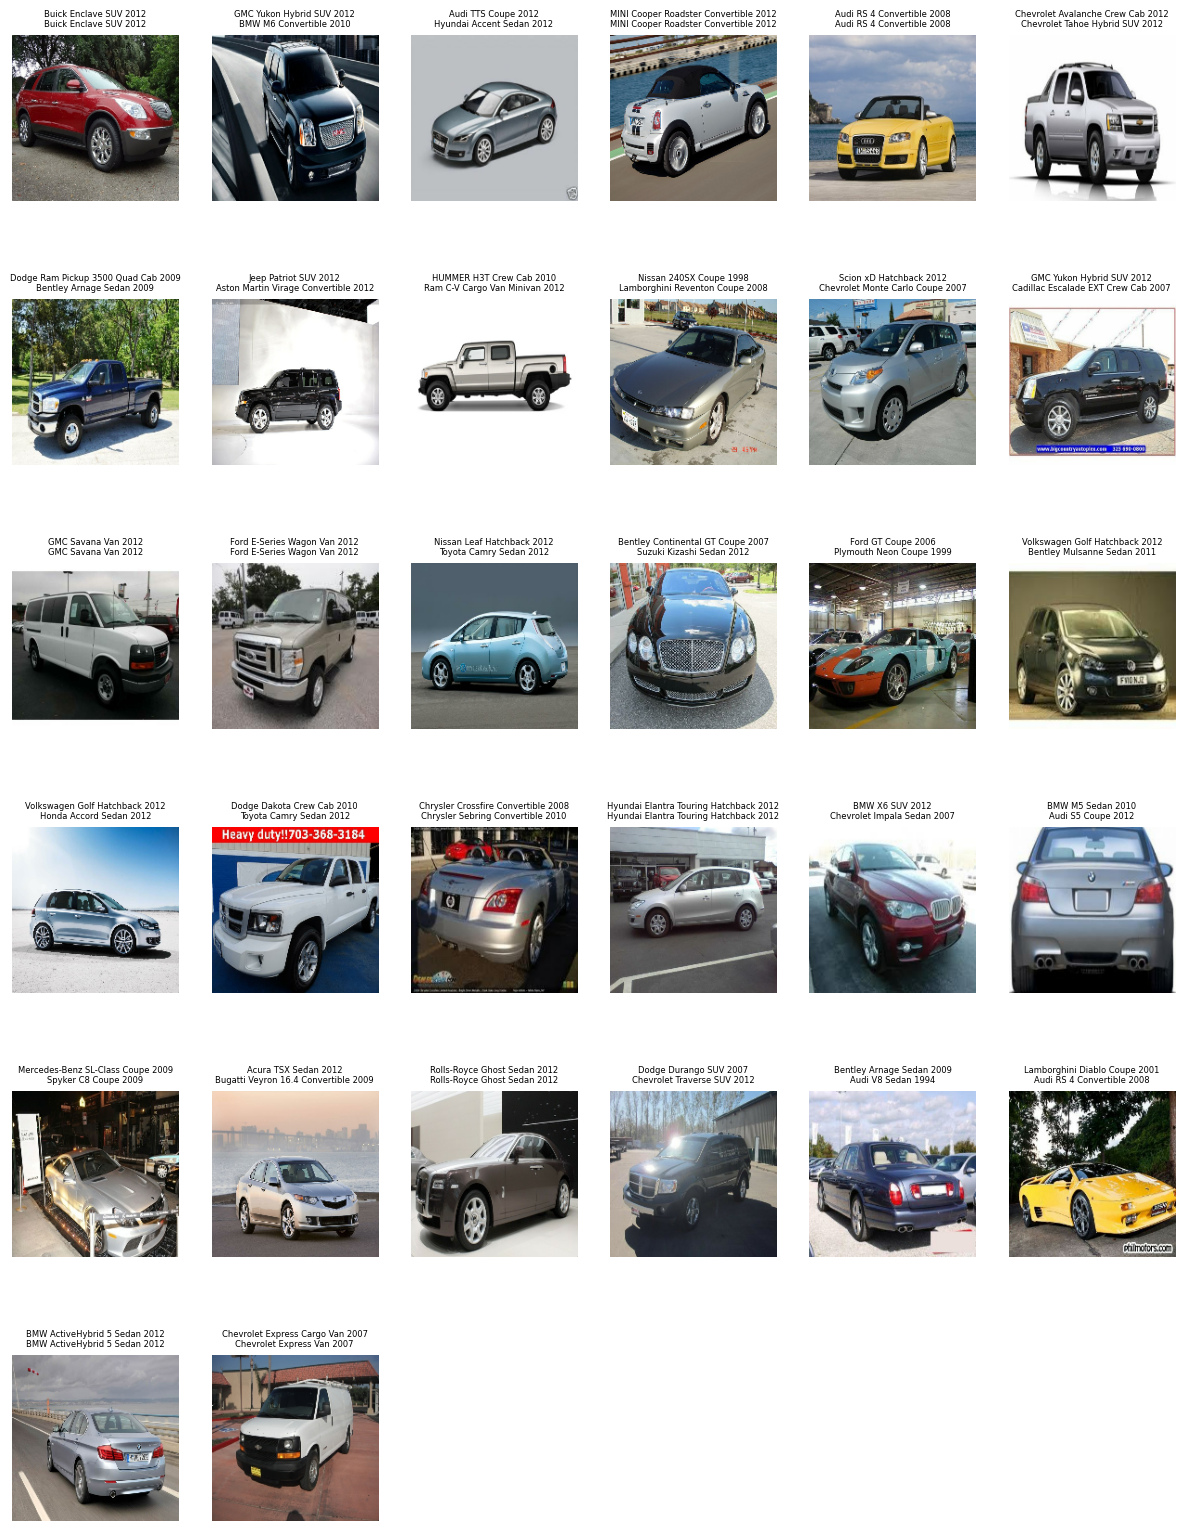

In [58]:
plt.figure(figsize=(15, 20))
acc = []
for images, labels in test.take(1):
    y1 = model.predict(images, batch_size = None)
    y1Labels = []
    for row in range(y1.shape[0]):
        y1Labels.append( test.class_names[np.argmax(y1[row,:])] )
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        t1 = test.class_names[labels[i]]
        title = t1 + "\n" + y1Labels[i]
        acc.append(t1 == y1Labels[i])
        plt.title(title, size = 6)
        plt.axis("off")
plt.savefig("196Classifier.png")
print("accuracy:", sum(acc)/len(acc))

https://towardsdatascience.com/keras-callbacks-and-how-to-save-your-model-from-overtraining-244fc1de8608#:~:text=We%20can%20use%20the%20Keras,at%20its%20best%20performing%20epoch.